<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/SimpleTurboFan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Turbofan Model
This notebook contains a simple turbofan model that will be used for cycle optimization and ML model training purposes.


The following station definitions will be used

| Number | Description |
|--------|-------------|
| ∞ | Ambient |
| 1 | Fan Inlet |
| 2 | Fan Outlet / Compressor Inlet |
| 2n | Fan Nozzle Outlet |
| 3 | Compressor Outlet / Burner Inlet |
| 4 | Burner Outlet / Turbine Inlet |
| 5 | Turbine Outlet / Nozzle Inlet |
| 6 | Nozzle Outlet |

The following are the assumed known design parameters for cycle analysis purposes.

| Symbol | Description | 
|--------|-------------|
| β | Fan to core bypass ratio |
| PR | Compressor pressure ratio |
| FRR | Fan pressure ratio |
| $T_4$ | Turbine inlet temperature (K)|
| $M_∞$ | Flight Mach number |
| $h_∞ $ | Altitude (m) |
| $η_f$ | Fan isentropic efficiency |
| $η_c$ | Compressor isentropic efficiency |
| $η_b$ | Burner efficiency |
| $η_t$ | Turbine isentropic efficiency |

## Thrust
For subsonic (or ideally expanded supersonic) nozzle exit Mach numbers, the thrust of the turbofan may be expressed as follows--

$$ T = \dot{m}_{fan} \left( U_{2n} - U_∞ \right) + \dot{m}_{core} \left( U_6 - U_∞ \right) $$

$$ \frac{T}{\dot{m}_{core}U_∞} = β\left(\frac{U_{2n}}{U_∞} - 1 \right) + \frac{U_{6}}{U_∞} - 1$$

In [ ]:
# Install CANTERA & ambience (ICAO standard atmosphere model)
%%capture
!pip install cantera ambiance

In [66]:
# Import the required modules
import cantera as ct
defaultMechanism = 'gri30.yaml'

from ambiance import Atmosphere

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight="bold")     # font size & weight of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, titleweight="bold")    # font size & weight of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold") 

import math
import numpy as np
from scipy.optimize import brentq, minimize, Bounds, minimize_scalar, root, basinhopping, dual_annealing
from scipy import constants
from copy import deepcopy

import pandas as pd
import networkx as nx

from abc import abstractmethod
from typing import Generic, Optional, SupportsFloat, Tuple, TypeVar, Union, List, Dict

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install --upgrade --force-reinstall git+https://github.com/davetew/Zero-Carbon-Aviation

In [ ]:
#from Zero_Carbon_Aviation import Propulsor 

In [ ]:
# Handy compressible flow relations

γ1 = lambda γ: γ / (γ-1) 

# Ratio of total to static temperature
θ = lambda Mach, γ=1.4: 1 + (γ-1)/2*Mach**2

# Ratio of total to static pressure
δ = lambda Mach, γ=1.4: θ(Mach, γ)**(γ1(γ))

# Handy temperature conversions 

# Kelvin to Celsius
K2C = lambda T_K: T_K - 273.15

# Celsius to Kelvin
C2K = lambda T_C: T_C + 273.15


In [ ]:
class Propulsor():

  def __init__(self, FPR, M0, isenEfficiency, γ=1.4):
    """Initialize an instance of Fan given the pressure ratio, flight Mach number and the isentropic efficiency"""
    self.FPR, self.M0, self.isenEfficiency, self.γ = FPR, M0, isenEfficiency, γ

  @property
  def γ1(self):
    """Convenient function of the ratio of specific heats"""
    return self.γ / (self.γ-1)

  @property
  def M_2n(self):
    """Fully expanded nozzle exit Mach number"""
    return np.sqrt( 2/(self.γ-1) * (self.FPR**(1/self.γ1)*θ(self.M0,self.γ) - 1) )

  @property
  def Tt2_Tt0(self):
    """Fan exit to inlet total temperature ratio"""
    return (self.FPR**(1/self.γ1) - 1)/self.isenEfficiency + 1

  @property
  def specificWork_cpTt0(self):
    """Dimensionless mass-specific input work"""
    return self.Tt2_Tt0 - 1

  @property
  def T2n_T0(self):
    """Fan nozzle exit to inlet static temperature ratio"""
    return θ(self.M0,self.γ) / θ(self.M_2n,self.γ) * self.Tt2_Tt0

  @property
  def U2n_U0(self):
    """Fan nozzle exit to flight velocity ratio"""
    return self.M_2n / self.M0 * np.sqrt(self.T2n_T0)

  @property
  def Thrust_m0U0(self):
    return self.U2n_U0 - 1

  @property
  def η_KE(self):
    """Fan kinetic energy efficiency = Delta Fan KE / Fan Aerodynamic Work"""
    return self.M0**2*(self.γ-1) / 2 / θ(self.M0,self.γ) * (self.U2n_U0**2 - 1) / (self.Tt2_Tt0-1)

  @property
  def η_propulsive(self):
    return 2*self.Thrust_m0U0 / ( self.U2n_U0**2 - 1)

  @property
  def η_overall(self):
    return self.η_KE*self.η_propulsive

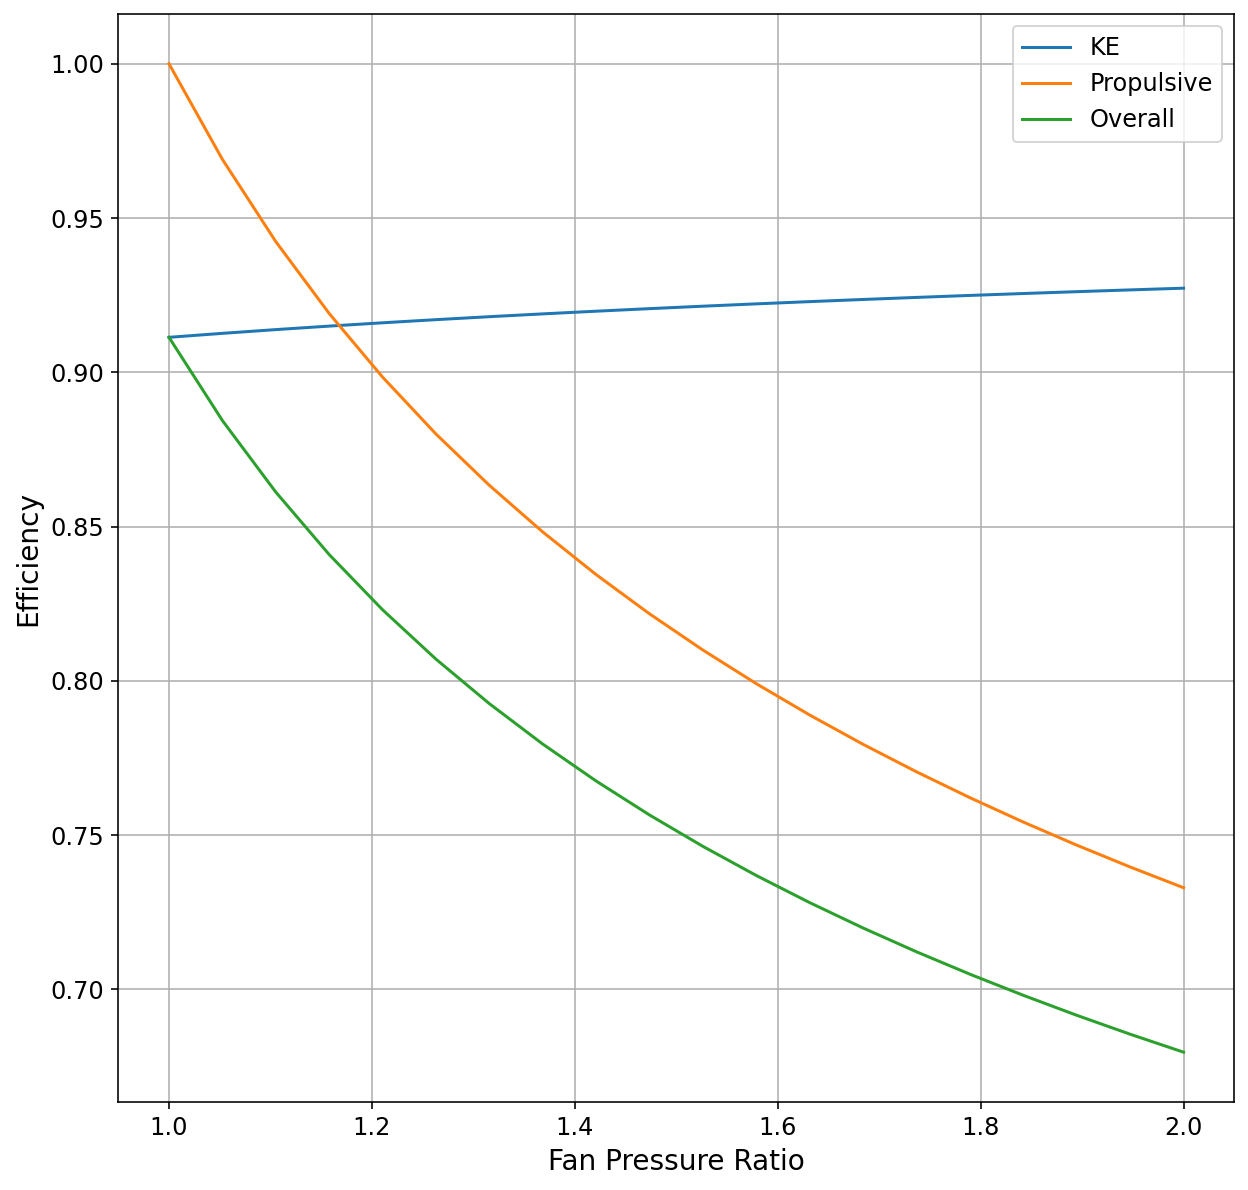

In [ ]:
# Array of fan pressure ratios
FPR = np.linspace(1.0+1e-6,2,20)

# Ambient static temperature
T0_K = 300

# Flight Mach number
M0 = 0.8

# Fan Efficiency
η_f = 0.9

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(FPR, list(map(lambda fpr: Propulsor(fpr, M0, η_f).η_KE, FPR)), label='KE')
ax.plot(FPR, list(map(lambda fpr: Propulsor(fpr, M0, η_f).η_propulsive, FPR)), label='Propulsive')
ax.plot(FPR, list(map(lambda fpr: Propulsor(fpr, M0, η_f).η_overall, FPR)), label='Overall')
ax.set_xlabel('Fan Pressure Ratio')
ax.set_ylabel('Efficiency')
plt.grid()
plt.legend();


In [ ]:
class SimpleBraytonCycle:

  # Ambient conditions

  def __init__(self, PR=None, Turbine_Inlet_Temperature_C=1500, 
              ηpoly_compressor=1.0, ηpoly_turbine=1.0,
              T_ambient_C=25, p_ambient_kPa=100, 
              R_J_kgK = 287.058, γ=1.4,
              target_mass_specific_work_kJ_kg=None,
              Turbine_Metal_Temperature_C=1200,
              StantonNumber=0.07,
              burnerPR=0.98, coolingPR=0.95):
    
    self.T_combustor_exit = Turbine_Inlet_Temperature_C + 273.15
    self.ηpoly = {"compressor": ηpoly_compressor,
                  "turbine": ηpoly_turbine}
    self.burnerPR = burnerPR
    self.coolingPR = coolingPR

    if Turbine_Metal_Temperature_C is None:
      self.Turbine_Metal_Temperature = self.T_combustor_exit
    else:
      self.Turbine_Metal_Temperature = Turbine_Metal_Temperature_C + 273.15

    self.StantonNumber=StantonNumber

    self.ambient = {'T_K': T_ambient_C + 273.15,
                    'p_Pa': p_ambient_kPa * 1000,
                    'γ': γ,
                    'R_J_kgK': 287,
                    'cp_J_kgK': R_J_kgK * γ / (γ-1)}
    if PR is None:
      # Calculate the PR that yields the target mass specific work
      if target_mass_specific_work_kJ_kg is None: 
        raise ValueError('Either PR or target_mass_specific_work must be specified.')
      self.PR = self.calcPR(target_mass_specific_work_kJ_kg)
    else:
      self.PR = PR

  def calcPR(self, target_work_kJ_kg):

    def δwork(pr):
      return ( SimpleBraytonCycle(PR=pr, 
                                  Turbine_Inlet_Temperature_C=self.T_combustor_exit - 273.15,
                                  ηpoly_compressor= self.ηpoly["compressor"],
                                  ηpoly_turbine=self.ηpoly["turbine"],
                                  T_ambient_C=self.ambient["T_K"] - 273.15, 
                                  p_ambient_kPa=self.ambient["p_Pa"]/1000, 
                                  R_J_kgK = self.ambient["R_J_kgK"], 
                                  γ=self.ambient["γ"],
                                  target_mass_specific_work_kJ_kg=None,
                                  Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature - 273.15,
                                  StantonNumber=self.StantonNumber,
                                  burnerPR=self.burnerPR,
                                  coolingPR=self.coolingPR,
                                  ).mass_specific_work/1000 -
                target_work_kJ_kg )

    # Calculate the PR that results in the target mass specific work
    try:
      pr, results = brentq(δwork, 1, 40, full_output=True)
    except ValueError:
      return np.nan

    # Return an answer if the solver converges
    return pr if results.converged else np.nan

  def optimize(self):
    """Optimize the cycle for maximum efficiency subject to the component efficiency and material
    temperature limits provided"""

    def inefficiency(x):
      """Calculate and return the 'inefficiency' or 1 - efficiency"""
      return 1 - SimpleBraytonCycle(PR=x[0], 
                                    Turbine_Inlet_Temperature_C=x[1],
                                    ηpoly_compressor= self.ηpoly["compressor"],
                                    ηpoly_turbine=self.ηpoly["turbine"],
                                    T_ambient_C=self.ambient["T_K"] - 273.15, 
                                    p_ambient_kPa=self.ambient["p_Pa"]/1000, 
                                    R_J_kgK = self.ambient["R_J_kgK"], 
                                    γ=self.ambient["γ"],
                                    target_mass_specific_work_kJ_kg=None,
                                    Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature - 273.15,
                                    StantonNumber=self.StantonNumber,
                                    burnerPR=self.burnerPR,
                                    coolingPR=self.coolingPR,
                                    ).efficiency

    try:
      results = minimize(inefficiency, [self.PR, self.T_combustor_exit], method='trust-constr', 
                         bounds=Bounds([1, 1273], [60, 2273]))

    except ValueError:
      return None
    
    else:
      if results.status == 1 or results.status == 2:
        self.PR = results.x[0]
        self.T_combustor_exit = results.x[1]
        return self 
      else:
        return None
    
  @property
  def T_compressor_exit(self):
    return self.ambient["T_K"]*self.PR**((self.ambient["γ"]-1)/self.ambient["γ"]/self.ηpoly["compressor"])

  @property
  def βcooling(self):
    """Turbine cooling / inlet mass flow ratio"""
    return ( self.StantonNumber*(self.T_combustor_exit-self.Turbine_Metal_Temperature) /
            (self.Turbine_Metal_Temperature - self.T_compressor_exit) )
    
  @property
  def turbinePR(self):
    """Turbine inlet to exhaust pressure ratio"""
    return self.PR*(self.burnerPR*(1-self.βcooling) + self.coolingPR*self.βcooling)  

  @property
  def T_turbine_inlet(self):
    """Temperature after mixing of combustor exit and cooling flows"""
    return self.T_compressor_exit*self.βcooling + self.T_combustor_exit*(1-self.βcooling)

  @property
  def T_turbine_exit(self):
    return self.T_turbine_inlet*self.turbinePR**(-(self.ambient["γ"]-1)*self.ηpoly["turbine"]/self.ambient["γ"])

  @property
  def mass_specific_heat_addition(self):
    return (self.T_combustor_exit - self.T_compressor_exit)*self.ambient["cp_J_kgK"]*(1-self.βcooling)

  @property
  def heat_addition_cpTin(self):
    """Calculate and return the dimensionaless specific heat addition/fuel lhv"""
    return self.mass_specific_heat_addition / self.ambient["cp_J_kgK"] / self.ambient["T_K"]

  @property
  def mass_specific_work(self):
    return ( self.T_turbine_inlet - self.T_turbine_exit - 
            (self.T_compressor_exit - self.ambient["T_K"]) )*self.ambient["cp_J_kgK"]

  @property
  def specific_work_cpTin(self):
    """Calculate and return the dimensionless specific work"""
    return self.mass_specific_work / self.ambient["T_K"] / self.ambient["cp_J_kgK"]

  @property
  def efficiency(self):
    return self.mass_specific_work / self.mass_specific_heat_addition

  @property
  def cycleTemperatures(self):
    return np.array([self.ambient["T_K"], self.T_compressor_exit,
                    self.T_combustor_exit, self.T_turbine_inlet,
                    self.T_turbine_exit] )

  @property
  def cyclePressures(self):
    return self.ambient["p_Pa"]* np.array([1, self.PR, self.PR*self.burnerPR, 
                                           self.turbinePR, 1])

  @property
  def cycleEnthalpies(self):
    return np.array([self.enthalpy(T) for T in self.cycleTemperatures])

  @property
  def cycleEntropies(self):
    return np.array( [self.entropy(T, p) for T, p in 
                      zip(self.cycleTemperatures, self.cyclePressures)] )  
    
  def enthalpy(self, T):
    """Calcuate and return the mass-specific enthalpy given the temperature in K"""
    return self.ambient["cp_J_kgK"]*(T - self.ambient["T_K"])

  def entropy(self, T, p):
    """Calcuate and return the mass-specific entropy given the temperature in K
    and pressure in Pa"""
    return ( self.ambient["cp_J_kgK"]*np.log(T/self.ambient["T_K"]) -
            self.ambient["R_J_kgK"]*np.log(p/self.ambient["p_Pa"]) )

  def cycleDiagrams(self):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

    # Temperature-Entropy Diagram
    ax1.plot(self.cycleEntropies, self.cycleTemperatures, marker='d')
    ax1.set_xlabel('Entropy (J/kg/K)')
    ax1.set_ylabel('Temperature ($^{\circ}$C)')
    ax1.grid()
    ax1.set_title(f'TS: Efficiency= {self.efficiency*100:0.0f}%')
    
    # Pressure-Enthalpy
    ax2.plot(self.cycleEnthalpies/1000, self.cyclePressures/1000, marker='p')
    ax2.set_xlabel('Enthalpy (kJ/kg)')
    ax2.set_ylabel('Pressure (kPa)')
    ax2.grid()
    ax2.set_title(f'PH: Specific Work={self.mass_specific_work/1000:.0f} kJ/kg')

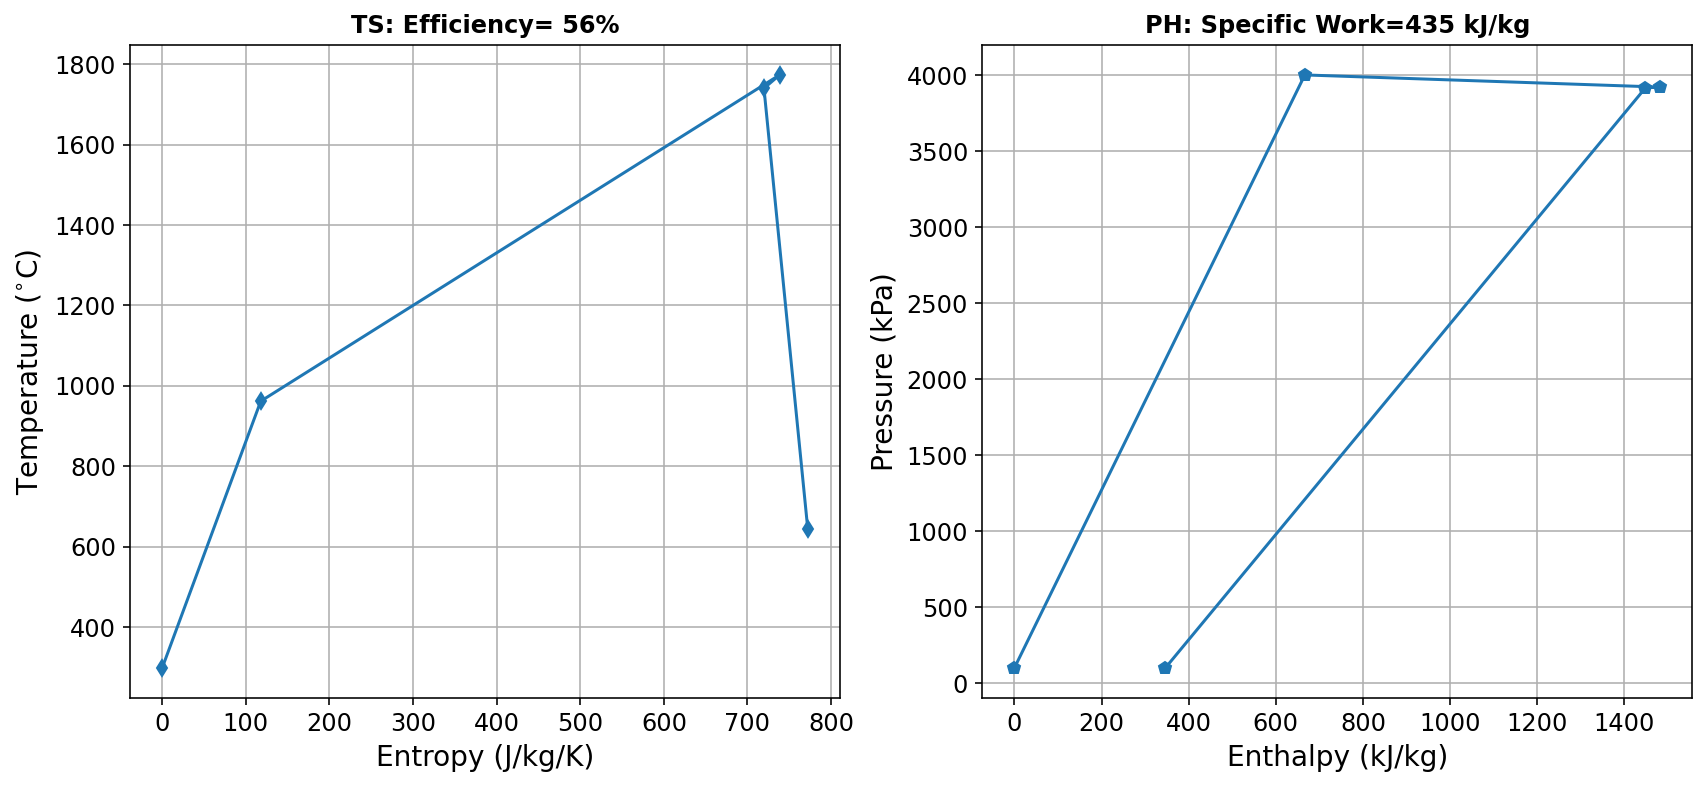

In [ ]:
SimpleBraytonCycle(PR=40,
                   ηpoly_compressor=0.9,
                   ηpoly_turbine=0.95).cycleDiagrams()

In [70]:
class SimpleTurboFan():
  """SimpleTurboFan is intend to provide rapid efficiency and specific 
  work estimates for turbofan engines.  """

  # Ambient air properties
  γ=1.4; R_J_kgK = 287.058
  γ1 = γ / (γ - 1)


  def __init__(self, Mach=0.8, Altitude_km = 10, FPR=None, ηisen_fan=0.9, β=2,
               CPR=30, Turbine_Inlet_Temperature_C=1500,
               ηpoly_compressor=1.0, ηpoly_turbine=1.0,
               target_mass_specific_work_kJ_kg=None,
               Turbine_Metal_Temperature_C=1200,
               StantonNumber=0.07,
               burnerPR=0.98, coolingPR=0.95 ):
    """Initialize an instance of SimpleTurboFan given    
      Mach: Flight Mach number,
      Altitude_km: Altitude in km, 
      FPR: Fan Pressure Ratio,
      ηisen_fan: Fan isentropic efficiency,
      β: Bypass (fan to core massflow) ratio
      CPR: Core compressor pressure ratio (Core)
      Turbine_Inlet_Temperature_C:
      ηpoly_compressor: Compressor polytropic efficiency, 
      ηpoly_turbine: Turbine polytropic efficiency,
      target_mass_specific_work_kJ_kg: ,
      Turbine_Metal_Temperature_C: Design (maximum turbine inlet temperature),
      StantonNumber: Stanton number for turbine heat transfer,
      burnerPR: Burner total pressure ratio, 
      coolingPR: Turbine cooling system pressure ratio 
    """
    
    # Save the input parameters
    self.Mach, self.Altitude_km, self.FPR, self.ηisen_fan = Mach, Altitude_km, FPR, ηisen_fan
    self.β, self.CPR, self.Turbine_Inlet_Temperature_C = β, CPR, Turbine_Inlet_Temperature_C
    self.ηpoly_compressor, self.ηpoly_turbine = ηpoly_compressor, ηpoly_turbine
    self.target_mass_specific_work_kJ_kg = target_mass_specific_work_kJ_kg
    self.Turbine_Metal_Temperature_C = Turbine_Metal_Temperature_C 
    self.StantonNumber = StantonNumber 
    self.burnerPR, self.coolingPR = burnerPR, coolingPR

    # Calculate either the FPR or β
    if FPR is None:
      # Calculate the FPR
      self.FPR = self.calcFPR()

    else:
      print('Bypass ratio calculation is not yet implemented.')
      pass

  def calcFPR(self):
    """Calculate the FPR that matches the work output of the core with the 
    work input of the fan"""

    def δwork(fpr):
      """Function to minimize to calculate the FPR - difference between
      the input fan work and the core output work"""
      self.FPR = fpr[0]
      return ( 1 - self.fan.specificWork_cpTt0 * self.β / 
              self.core.specific_work_cpTin * self.fan.Tt2_Tt0 )
    
    try:
      results = root(δwork, x0=1.1, tol=1e-3)

    except ValueError:
      return None
  
    else:
      if results.status == 1 or results.status == 2:
        return results.x[0]

      else:
        return None
    
  @property
  def ambient(self):
    """Calculate and return the ambient static conditions"""
    return {'p_kPa': Atmosphere(self.Altitude_km*1000).pressure[0]/1000,
            'T_K': Atmosphere(self.Altitude_km*1000).temperature[0]}

  @property
  def fan(self):
    """Initate and return an instance of Propulsor for the fan"""
    return Propulsor(self.FPR, self.Mach, self.ηisen_fan)

  @property
  def core_inlet_total(self):
    """Calculate and return the core inlet total temperature and pressure"""
    return {'p_kPa': self.ambient['p_kPa']*δ(self.Mach)*self.FPR,
            'T_K': self.ambient['T_K']*θ(self.Mach)*self.fan.Tt2_Tt0}

  @property
  def core(self):
    """Initiate and return an instance of SimpleBraytonCycle for the core"""
    return SimpleBraytonCycle(PR = self.CPR,
                              Turbine_Inlet_Temperature_C=self.Turbine_Metal_Temperature_C,
                              ηpoly_compressor=self.ηpoly_compressor,
                              ηpoly_turbine=self.ηpoly_turbine,
                              T_ambient_C= K2C(self.core_inlet_total['T_K']), 
                              p_ambient_kPa= self.core_inlet_total['p_kPa'],
                              target_mass_specific_work_kJ_kg=self.target_mass_specific_work_kJ_kg,
                              Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature_C, 
                              StantonNumber=self.StantonNumber, 
                              burnerPR=self.burnerPR, coolingPR=self.coolingPR)

  @property
  def coreNozzle(self):
    """Calculate the core nozzle fully expanded exit Mach number and velocity"""

    coreNozzle = {}

    # Nozzle inlet (exit - isentropic nozzle) total to exit static pressure ratio
    coreNozzle['Ptin_pexit'] = δ(self.Mach) * self.FPR * self.CPR * self.burnerPR / self.core.turbinePR
    
    # Nozzle exit Mach number
    coreNozzle['Mach'] = np.sqrt( 2/(self.γ-1) * (coreNozzle['Ptin_pexit']**(1/self.γ1) - 1))

    # Nozzle inlet (exit - isentropic nozzle) total to flight total temperature ratio
    coreNozzle['Tt6_Tt0'] = self.core.T_turbine_exit / self.core.ambient['T_K'] * self.fan.Tt2_Tt0

    # Nozzle exit to flight velocity ratio
    coreNozzle['U6_U0'] = coreNozzle['Mach'] / self.Mach * np.sqrt( coreNozzle['Tt6_Tt0'] * 
                                                                    θ(self.Mach) / θ(coreNozzle['Mach']))
    
    return coreNozzle

  @property
  def thrust_mcU0(self):
    """Calculate and return the dimensionless thrust -- total thrust / core mass flow rate / flight velocity"""

    thrust_mcU0 = {}

    # Re-normalized fan thrust
    thrust_mcU0['fan'] = self.fan.Thrust_m0U0 * ( self.β - 1 )

    # Core thrust
    thrust_mcU0['core'] = self.coreNozzle['U6_U0'] - 1

    thrust_mcU0['overall'] = thrust_mcU0['fan'] + thrust_mcU0['core']

    return thrust_mcU0

  @property
  def η_overall(self):
    """Overall efficiency -- thrust power / fuel LHV"""
    return ( self.thrust_mcU0['overall'] / self.core.heat_addition_cpTin / self.fan.Tt2_Tt0 *
            self.Mach**2 * (self.γ-1) / θ(self.Mach) )
    
  def optimizeCycle(self):
    """Optimize the overall turbofan design (β, CPR) for maximum efficiency"""

    def inefficiency(x):
      """Calculate and return 1 - η_overall for the specified bypass and compressor pressure ratios"""
      
      ineff = 1 - SimpleTurboFan(Mach=self.Mach, 
                                Altitude_km = self.Altitude_km, FPR=None, 
                                ηisen_fan=self.ηisen_fan, β=x[0],
                                CPR=x[1], Turbine_Inlet_Temperature_C=self.Turbine_Inlet_Temperature_C,
                                ηpoly_compressor=self.ηpoly_compressor, ηpoly_turbine=self.ηpoly_turbine,
                                target_mass_specific_work_kJ_kg=None,
                                Turbine_Metal_Temperature_C=self.Turbine_Metal_Temperature_C,
                                StantonNumber=self.StantonNumber,
                                burnerPR=self.burnerPR, coolingPR=self.coolingPR).η_overall 
      print(f'β={x[0]}, CPR={x[1]}, Inefficiency = {ineff}, η_overall={1 - ineff}')
      return ineff

    # Optimize the cycle for maximum overall efficiency
    try:
      print(f'Begin optimization β={self.β}, CPR={self.CPR}')
#      results = minimize(inefficiency, [self.β, self.CPR], method='trust-constr', 
#                          bounds=Bounds([1, 20], [1, 60]), options={'disp': True})
#      results = basinhopping(inefficiency, [self.β, self.CPR], niter=10)
      results = dual_annealing(inefficiency, bounds=[(1, 20), (1, 60)])
#                             minimizer_kwargs={'method': 'SLSQP', 
#                                               'bounds': Bounds([1.01, 20], [1.01, 60]), 
#                                               'options':{'disp': True}})

      print(results)

    except ValueError:
      return None
    
    else:
      if results.status == 1 or results.status == 2:
        self.β = results.x[0]
        self.CPR = results.x[1]
        self.calcFPR()
        return self 
      else:
        return None


In [71]:
test = SimpleTurboFan(β=9, CPR=30, ηpoly_compressor=0.9, ηpoly_turbine=0.95)
print(f'Fan Pressure Ratio = {test.FPR}')
print(f'Overall Presure Ratio = {test.FPR * test.CPR}')
print(f'Turbine PR = {test.core.turbinePR}')
print(f'Fan Nozzle Pressure Ratio = {test.FPR*δ(test.Mach)}')
print(f'Fan Nozzle Exit Mach Number = {test.fan.M_2n}')
print(f'Core Nozzle Pressure Ratio = {test.coreNozzle["Ptin_pexit"]}')
print(f'Core Nozzle Exit Mach Number = {test.coreNozzle["Mach"]}')
print(f'Thrust = {test.thrust_mcU0}')
print(f'Efficiency = {test.η_overall}')

Fan Pressure Ratio = 1.4269403096732927
Overall Presure Ratio = 42.80820929019878
Turbine PR = 29.4
Fan Nozzle Pressure Ratio = 2.175142205287008
Fan Nozzle Exit Mach Number = 1.1149101468790006
Core Nozzle Pressure Ratio = 2.175142205287008
Core Nozzle Exit Mach Number = 1.114910146879001
Thrust = {'fan': 3.2087701959766246, 'core': 1.0248243997145483, 'overall': 4.233594595691173}
Efficiency = 0.37588367545444956


In [72]:
test.optimizeCycle()
print(f'Efficiency = {test.η_overall}')
print(f'Thrust = {test.thrust_mcU0}')
print(f'Fan Pressure Ratio = {test.FPR}')
print(f'Overall Pressure Ratio = {test.FPR * test.CPR}')
print(f'Compressor Pressure Ratio = {test.CPR}')
print(f'Bypass Ratio = {test.β}')
print(f'Core Nozzle Exit Mach Number = {test.coreNozzle["Mach"]}')


Begin optimization β=9, CPR=30
β=8.923814649160096, CPR=7.355705049569522, Inefficiency = 0.7056580449451786, η_overall=0.2943419550548214
β=1.4291785880923271, CPR=50.306122166104615, Inefficiency = 0.7361008269621574, η_overall=0.2638991730378426
β=10.380021598335588, CPR=29.256965176347876, Inefficiency = 0.6141538872076233, η_overall=0.3858461127923767
β=3.91339910030365, CPR=29.256965176347876, Inefficiency = 0.692440932174105, η_overall=0.30755906782589504
β=3.91339910030365, CPR=49.51957020908594, Inefficiency = 0.6650422785136372, η_overall=0.3349577214863628
β=10.380021598335588, CPR=29.256965176347876, Inefficiency = 0.6141538872076233, η_overall=0.3858461127923767
β=10.38002160833559, CPR=29.256965176347876, Inefficiency = 0.6141538871316435, η_overall=0.38584611286835646
β=10.380021598335588, CPR=29.256965186347877, Inefficiency = 0.6141538871883414, η_overall=0.3858461128116586
β=10.387619575509405, CPR=29.258893367128586, Inefficiency = 0.6140924683869566, η_overall=0.385

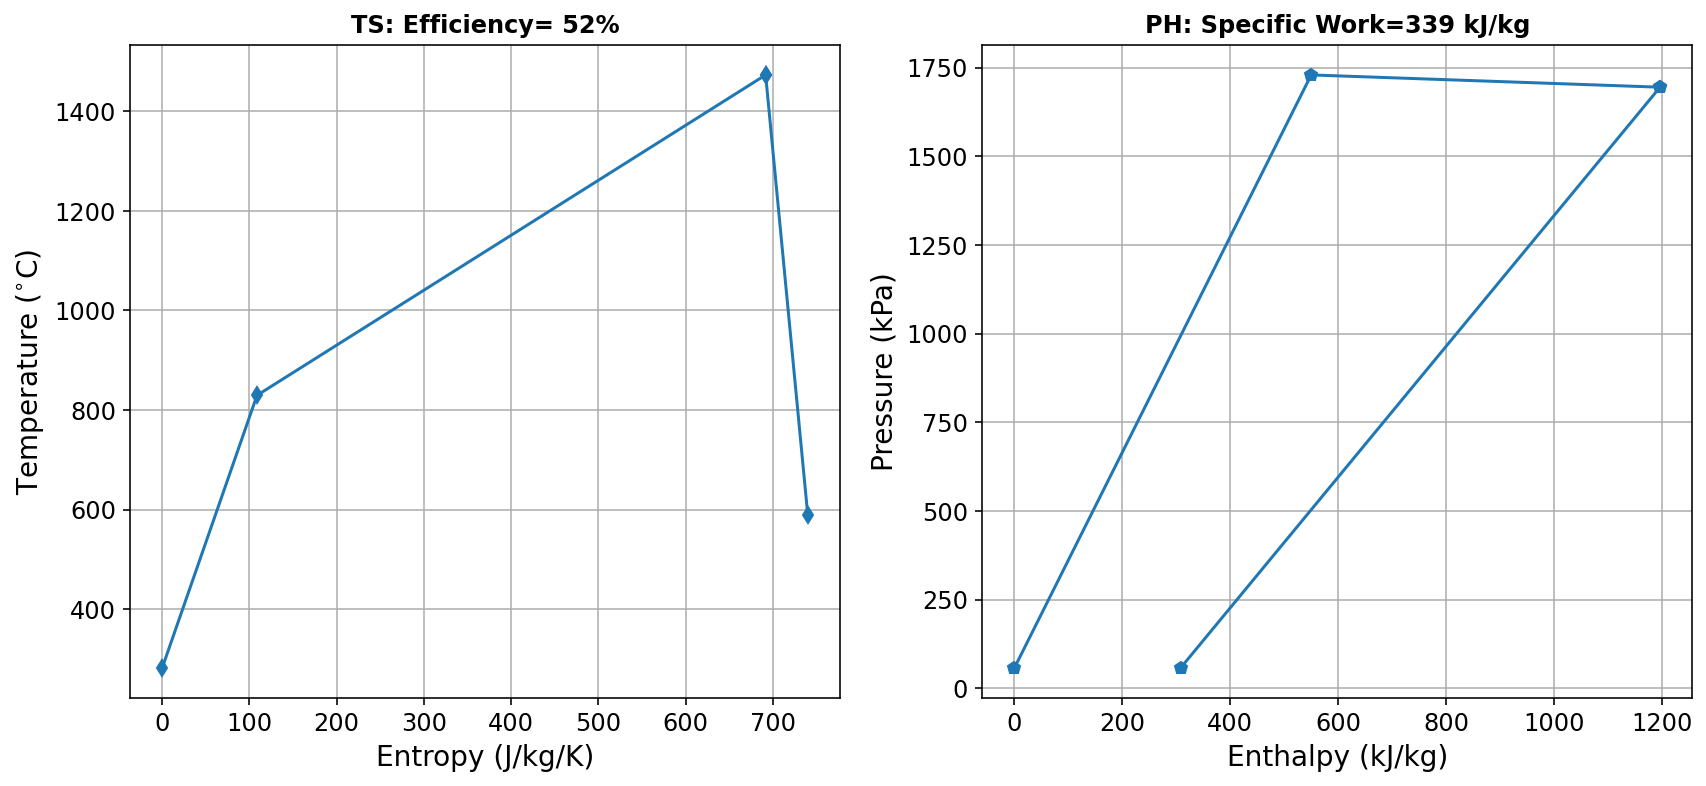

In [73]:
test.core.cycleDiagrams()